# Occupancy detection

### A multivariate time series example

In this tutorial, you will learn how to apply getML to multivariate time series. It also demonstrates how to use getML's [high-level interface for hyperparameter tuning](https://docs.getml.com/latest/user_guide/hyperopt/hyperopt.html#tuning-routines).

Summary:

- Prediction type: __Binary classification__
- Domain: __Energy__
- Prediction target: __Room occupancy__ 
- Source data: __1 table, 32k rows__
- Population size: __32k__

_Author: Dr. Johannes King_

# Background

Our use case is a public domain data set for predicting room occupancy from sensor data. The results achieved using getML outperform all published results on this data set. Note that this is not only a neat use case for machine learning algorithms, but a real-world application with tangible consequences: If room occupancy is known with sufficient certainty, it can be applied to the control systems of a building. Such as system can reduce the energy consumption by [up to 50 %](https://ieeexplore.ieee.org/document/7566062).


### Introduction to occupancy prediction

Usually, getML is considered to be a tool for feature engineering and machine learning on relational data sets. How can we apply it to (multivariate) time series?

The key is a _self-join_. Instead of creating features by merging and aggregating peripheral tables in a relational data model, for a time-series, we perform the same operations on the population table itself. This results in features like these:

* Aggregations over time, such as the average value of some column for the last 3 days.

* Seasonal effects, such as today is a Wednesday, so let's get the average value for the last four Wednesdays.

* Lag variables, such as get the value of some column from two hours ago.

Using getML's algorithms for relational learning, we can extract all of these features automatically. Having created a flat table of such features, we can then apply state-of-the-art machine learning algorithms, like xgboost. As you will see in this example, this performs better than traditional time series analysis.

The present analysis is based on a public domain time series dataset. It is available in the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+). The challenge is straightforward: We want to predict whether an office room is occupied at a given moment in time using sensor data. The data is measured about once a minute. Ground-truth occupancy was obtained from time-stamped pictures. The available columns are

* Date, year-month-day hour:minute:second
* Temperature, in Celsius
* Relative Humidity, %
* Light, in Lux
* CO2, in ppm
* Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
* Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

As a reference and benchmark, we use [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0378778815304357):

> Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, Veronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.

The authors apply various artifical neural networks algorithms to the data set at hand and achieved accuracies between 80.324% (batch back algorithm) and 99.061% (limited memory quasi-Newton algorithm).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set-up your session:

In [1]:
import os
import numpy as np
import pandas as pd
from urllib import request
from IPython.display import Image, Markdown
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project('occupancy')

getML API version: 1.0.0



Connected to project 'occupancy'


## 1. Loading data


The data set can be downloaded directly from GitHub. It is conveniently separated into a training, a validation and a testing set. This allows us to directly benchmark our results against the results of the original paper later.

In [2]:
directory = '.temp/'

fnames = [
    'datatraining.txt',
    'datatest.txt',
    'datatest2.txt'
]

if not os.path.exists(directory):
    os.makedirs(directory)

for fname in fnames:
    if not os.path.exists(directory + fname):
        fname, res = request.urlretrieve(
            "https://raw.githubusercontent.com/LuisM78/Occupancy-detection-data/master/" + fname, 
            directory + fname
        )


The data file contain the row number Because the data files are not valid CSV, we first load them into pandas before uploading them to the getML engine.

In [3]:
datatraining_pandas = pd.read_csv(directory + 'datatraining.txt')
datatest_pandas = pd.read_csv(directory + 'datatest.txt')
datatest2_pandas = pd.read_csv(directory + 'datatest2.txt')

data_train = getml.data.DataFrame.from_pandas(datatraining_pandas, name='data_train')
data_validate = getml.data.DataFrame.from_pandas(datatest_pandas, name='data_validate')
data_test = getml.data.DataFrame.from_pandas(datatest2_pandas, name='data_test')

In [4]:
data_all, split = getml.data.split.concat(
    "data_all", 
    train=data_train,
    validation=data_validate,
    test=data_test,
)

The training set looks like this:

In [5]:
data_all

name,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,date
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
0,23.18,27.272,426,721.25,0.004793,1,2015-02-04 17:51:00
1,23.15,27.2675,429.5,714,0.004783,1,2015-02-04 17:51:59
2,23.15,27.245,426,713.5,0.004779,1,2015-02-04 17:53:00
3,23.15,27.2,426,708.25,0.004772,1,2015-02-04 17:54:00
4,23.1,27.2,426,704.5,0.004757,1,2015-02-04 17:55:00
,...,...,...,...,...,...,...
20555,20.815,27.7175,429.75,1505.25,0.004213,1,2015-02-18 09:15:00
20556,20.865,27.745,423.5,1514.5,0.00423,1,2015-02-18 09:16:00
20557,20.89,27.745,423.5,1521.5,0.004237,1,2015-02-18 09:16:59


In [6]:
split

,
0,train
1,train
2,train
3,train
4,train
,...


We also assign roles to each column. To learn more about what roles do and why we need them, check out the [official documentation](https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html).

In [7]:
data_all.set_role(['Occupancy'], getml.data.roles.target)
data_all.set_role(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], getml.data.roles.numerical)
data_all.set_role(['date'], getml.data.roles.time_stamp)
    
data_all

name,date,Occupancy,Temperature,Humidity,Light,CO2,HumidityRatio
role,time_stamp,target,numerical,numerical,numerical,numerical,numerical
unit,"time stamp, comparison only",,,,,,
0,2015-02-04 17:51:00,1,23.18,27.272,426,721.25,0.004793
1,2015-02-04 17:51:59,1,23.15,27.2675,429.5,714,0.004783
2,2015-02-04 17:53:00,1,23.15,27.245,426,713.5,0.004779
3,2015-02-04 17:54:00,1,23.15,27.2,426,708.25,0.004772
4,2015-02-04 17:55:00,1,23.1,27.2,426,704.5,0.004757
,...,...,...,...,...,...,...
20555,2015-02-18 09:15:00,1,20.815,27.7175,429.75,1505.25,0.004213
20556,2015-02-18 09:16:00,1,20.865,27.745,423.5,1514.5,0.00423


## 2. Predictive modeling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

We use a [Multirel](https://docs.getml.com/latest/api/getml.models.MultirelModel.html) for generating the features and a simple logistic regression for prediction.

We do not spend much effort on the hyperparameters and largely go with the default values. The only exception is that we add some regularization to the XGBoostClassifiers.

We choose to consider data within the last 15 minutes for creating our features.

In [8]:
# Our forecast horizon is 0.
# We do not predict the future, instead we infer 
# the present state from current and past sensor data.
horizon = 0.0

# We do not allow the time series features
# to use target values from the past.
# (Otherwise, we would need the horizon to
# be greater than 0.0).
allow_lagged_targets = False

# We want our time series features to only use
# data from the last 15 minutes
memory = getml.data.time.minutes(15)

time_series = getml.data.TimeSeries(
    population=data_all,
    split=split,
    time_stamps="date",
    horizon=horizon,
    memory=memory,
    lagged_targets=allow_lagged_targets,
)

time_series

data model

  population:
    columns:
    - Temperature: numerical
    - Humidity: numerical
    - Light: numerical
    - CO2: numerical
    - HumidityRatio: numerical
    - ...

    joins:
    - right: 'data_all'
      time_stamps: (population.date, data_all.date)
      relationship: 'many-to-many'
      memory: 900.0
      horizon: 0.0
      lagged_targets: False

  data_all:
    columns:
    - Temperature: numerical
    - Humidity: numerical
    - Light: numerical
    - CO2: numerical
    - HumidityRatio: numerical
    - ...


container

  population
      subset       name       rows   type
  0   test         data_all   9751   View
  1   train        data_all   8144   View
  2   validation   data_all   2665   View

  peripheral
      name        rows   type     
  0   data_all   20560   DataFrame

In [9]:
feature_learner = getml.feature_learning.Multirel(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
)

predictor = getml.predictors.LogisticRegression()

pipe = getml.pipeline.Pipeline(
    data_model=time_series.data_model,
    tags=["memory=15", "logistic regression"],
    feature_learners=[feature_learner],
    predictors=[predictor]
)

pipe

Pipeline(data_model='population',
         feature_learners=['Multirel'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['data_all'],
         predictors=['LogisticRegression'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['memory=15', 'logistic regression'])

`.check(...)` will be automatically called by `.fit(...)`. But it is always a good idea to call `.check(...)` separately before fitting, so we still have time for some last-minute fixes.

In [10]:
pipe.check(time_series.train)

Checking data model...


Staging...
[========================================] 100%

OK.


### 2.2 Model training

We use a routine for automatic [hyperparameter optimization](https://docs.getml.com/latest/api_documentation/python/hyperopt.html) to find the best parameters for the predictor:

In [11]:
pipe = getml.hyperopt.tune_predictors(pipe, time_series)

Checking data model...


Staging...
[========================================] 100%

OK.


Tuning logistic regression...
[========================================] 100%

Time taken: 0h:2m:57.720395

Building final pipeline...

Checking data model...


Staging...
[========================================] 100%

OK.


Staging...
[========================================] 100%

Multirel: Training features...
[========================================] 100%

Multirel: Building features...
[========================================] 100%

Staging...
[========================================] 100%

Multirel: Building features...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:1m:37.048664



Staging...
[========================================] 100%

Multirel: Building features...
[========================================] 100%



The logistic regression has one hyperparameter that can be optimized, namely its L2 regularization parameter. We fine-tune this parameter using the validation set. Note that the validation set is different from the testing set on which the final outcome will be evaluated.

### 2.3 Model evaluation

Let's see how well we did by scoring the model on the testing set.

In [12]:
pipe.score(time_series.test)



Staging...
[========================================] 100%

Multirel: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-08-06 14:41:01,train,Occupancy,0.9887,0.9946,0.5783
1,2021-08-06 14:41:14,validation,Occupancy,0.9786,0.9921,0.5556
2,2021-08-06 14:42:09,test,Occupancy,0.9933,0.9976,0.5786


In the [original paper](http://www.worldresearchlibrary.org/up_proc/pdf/568-148612088816-20.pdf), the authors tried several approaches. The best out-of-sample values of all the approaches they tried are the following:

* Accuracy (testing): 0.99061
* AUC (testing): 0.99574

Note that our results outperform the best approach from the original paper, both in terms of accuracy as well as AUC. 
This demonstrates how powerful getML's relational learning approach is also a powerful tool for time series.

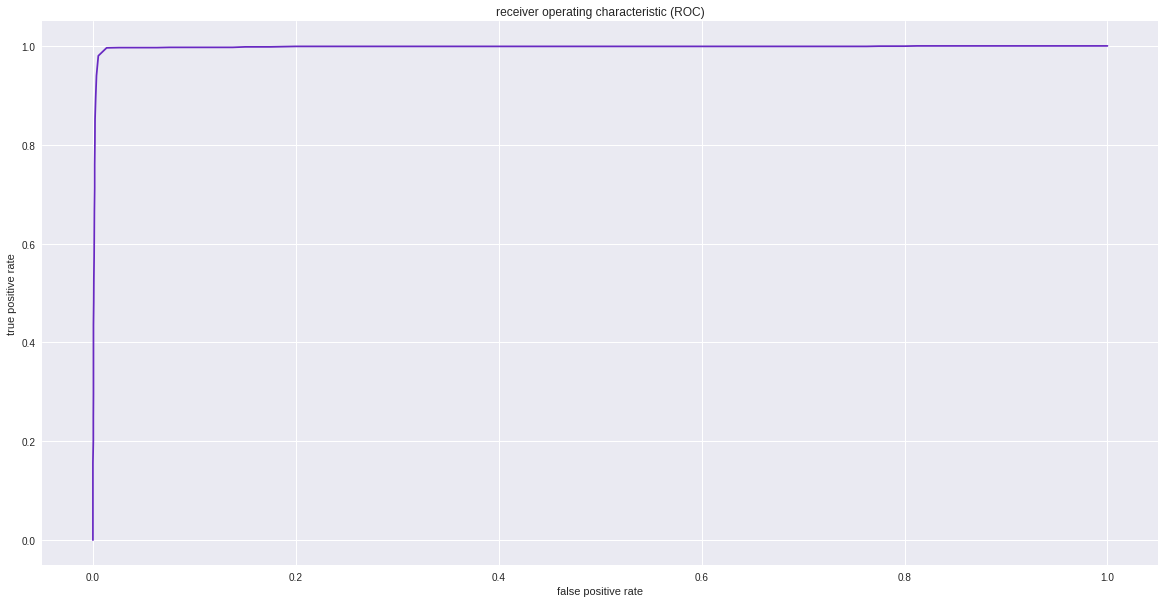

In [13]:
# Refers to the data from the last time
# we called .score(...).
fpr, tpr = pipe.plots.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr, tpr, color='#6829c2')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

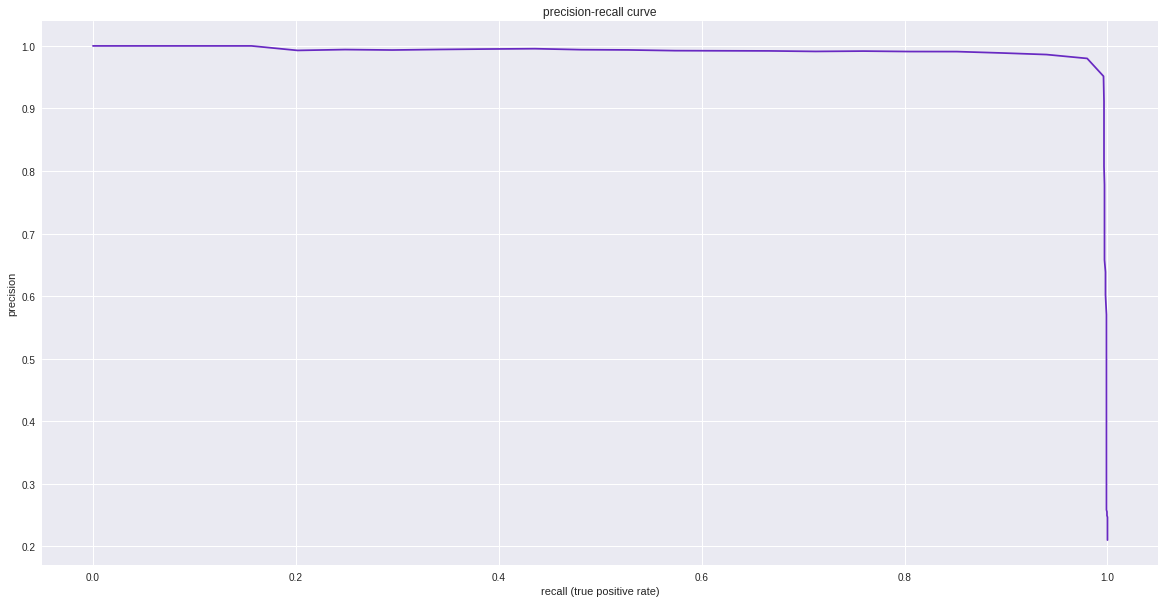

In [14]:
# Refers to the data from the last time
# we called .score(...).
recall, precision = pipe.plots.precision_recall_curve()

plt.subplots(figsize=(20, 10))

plt.plot(recall, precision, color='#6829c2')

plt.title("precision-recall curve")
plt.grid(True)
plt.xlabel("recall (true positive rate)")
plt.ylabel("precision")

plt.show()

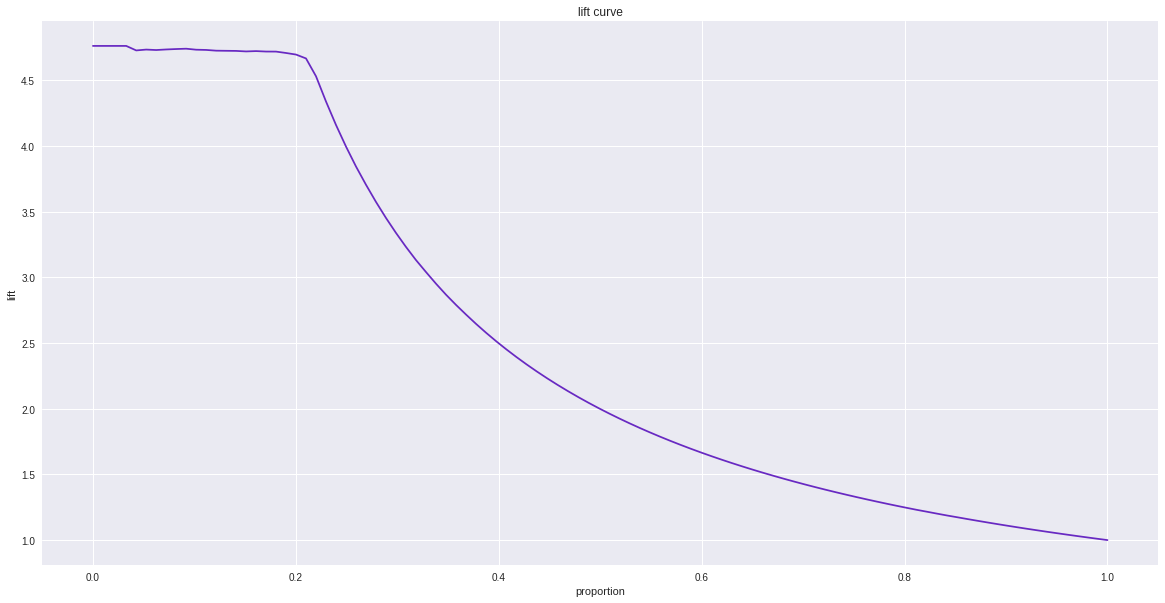

In [15]:
# Refers to the data from the last time
# we called .score(...).
proportion, lift = pipe.plots.lift_curve()

plt.subplots(figsize=(20, 10))

plt.plot(proportion, lift, color='#6829c2')

plt.title("lift curve")
plt.grid(True)
plt.xlabel("proportion")
plt.ylabel("lift")

plt.show()

### 2.4 Studying the features

It is always a good idea to study the features the relational learning algorithm has extracted. We can do so in the [feature view](https://docs.getml.com/latest/user_guide/getml_suite/monitor/models.html#feature-view) of the getML monitor. Open the monitor and select the models tab in the sidebar. You will see an overview over the trained pipelines. Select a pipeline to see the most essential summary plots. 

If you want to document them inside your notebook, here is how you can do that:

In [16]:
pipe.features.to_pandas()

,names,correlations,importances,target,sql
0,feature_1_1,0.979036,0.009952,Occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_1"";\n\nCREATE ..."
1,feature_1_2,0.978453,0.009949,Occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_2"";\n\nCREATE ..."
2,feature_1_3,0.972553,0.009636,Occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_3"";\n\nCREATE ..."
3,feature_1_4,-0.977636,0.009951,Occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_4"";\n\nCREATE ..."
4,feature_1_5,0.975472,0.009644,Occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_5"";\n\nCREATE ..."
...,...,...,...,...,...
100,temperature,0.521735,0.005516,Occupancy,
101,humidity,-0.087848,0.001260,Occupancy,
102,light,0.914508,0.009370,Occupancy,
103,co2,0.261785,0.007245,Occupancy,


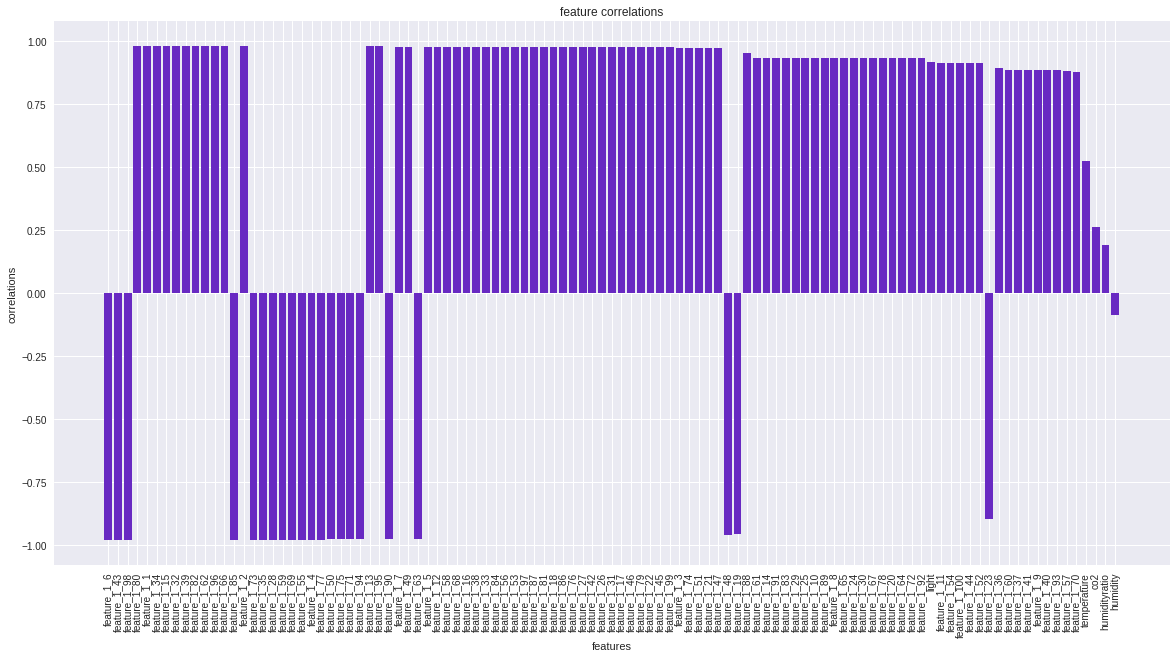

In [17]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

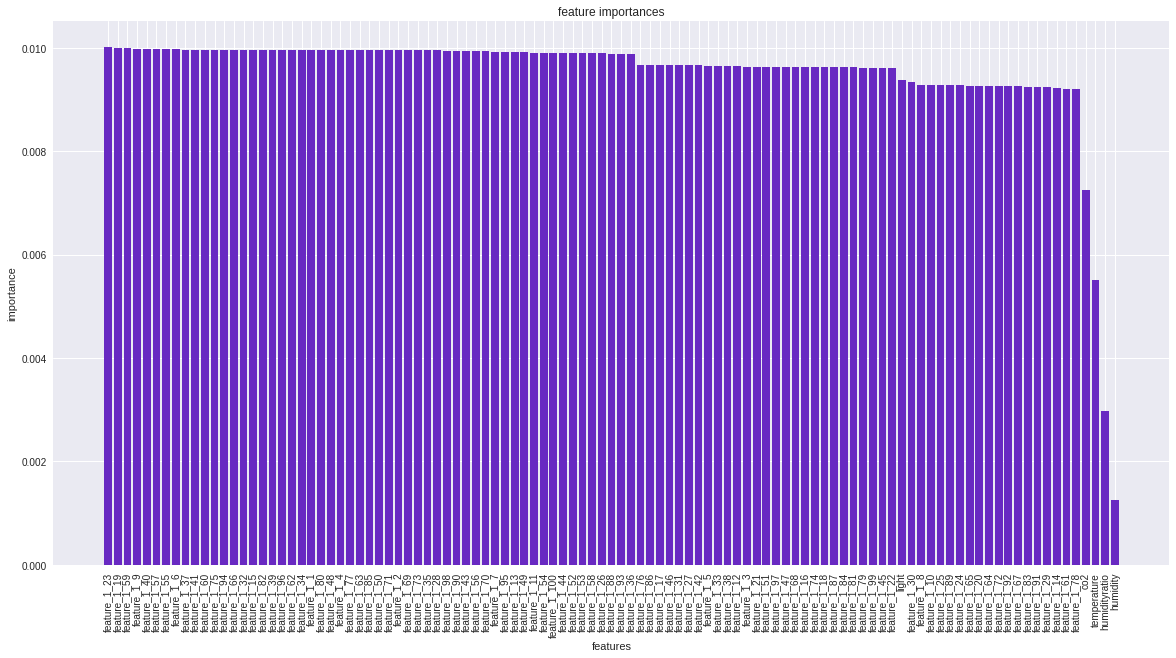

In [18]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

The feature importance is calculated by XGBoost based on the improvement of the optimizing criterium at each split in the decision tree and is normalized to 100%. 

We first look at the most important feature. The names returned by feature importances are already sorted, so we can just index them, like this:

In [19]:
pipe.features.to_sql()[names[0]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_23";

CREATE TABLE "FEATURE_1_23" AS
SELECT MAX( t1."date" - t2."date" ) AS "feature_1_23",
       t1.rowid AS "rownum"
FROM "POPULATION__STAGING_TABLE_1" t1
LEFT JOIN "DATA_ALL__STAGING_TABLE_2" t2
ON 1 = 1
WHERE ( t2."date" <= t1."date"
AND ( t2."date, '+15.000000 minutes'" > t1."date" OR t2."date, '+15.000000 minutes'" IS NULL )
) AND (
   ( ( t1."light" > 386.583333 OR t1."light" IS NULL  ) AND ( t2."light" > 609.161616 ) )
OR ( ( t1."light" <= 386.583333 ) )
)
GROUP BY t1.rowid;
```

Let's check out the second most important feature.

In [20]:
pipe.features.to_sql()[names[1]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_19";

CREATE TABLE "FEATURE_1_19" AS
SELECT MIN( t1."date" - t2."date" ) AS "feature_1_19",
       t1.rowid AS "rownum"
FROM "POPULATION__STAGING_TABLE_1" t1
LEFT JOIN "DATA_ALL__STAGING_TABLE_2" t2
ON 1 = 1
WHERE ( t2."date" <= t1."date"
AND ( t2."date, '+15.000000 minutes'" > t1."date" OR t2."date, '+15.000000 minutes'" IS NULL )
) AND (
   ( ( t2."light" > 465.562724 OR t2."light" IS NULL  ) AND ( t2."light" <= 560.225000 ) )
OR ( ( t2."light" <= 465.562724 ) AND ( t1."date" - t2."date" > 781.593284 ) )
OR ( ( t2."light" <= 465.562724 ) AND ( t1."date" - t2."date" <= 781.593284 ) AND ( t2."light" > 365.490234 ) AND ( t1."light" > 5.338384 ) )
)
GROUP BY t1.rowid;
```

These two features demonstrate the power of the getML feature learning algorithms. It is very unlikely to find these features using manual, trial-and-error based methods. The general structure of features found using such methods might be similar, but you would have had to put in much more effort while getting worse results.

When browsing through the remaining features, you will notice that some are columns directly taken from the original table, such as *Light* and *CO2*. But these columns are less correlated and less important than the features generated with the relational model based on self-join and upper time stamps.

Because getML uses a feature learning approach, the concept of feature importances can also be carried over to the individual columns.

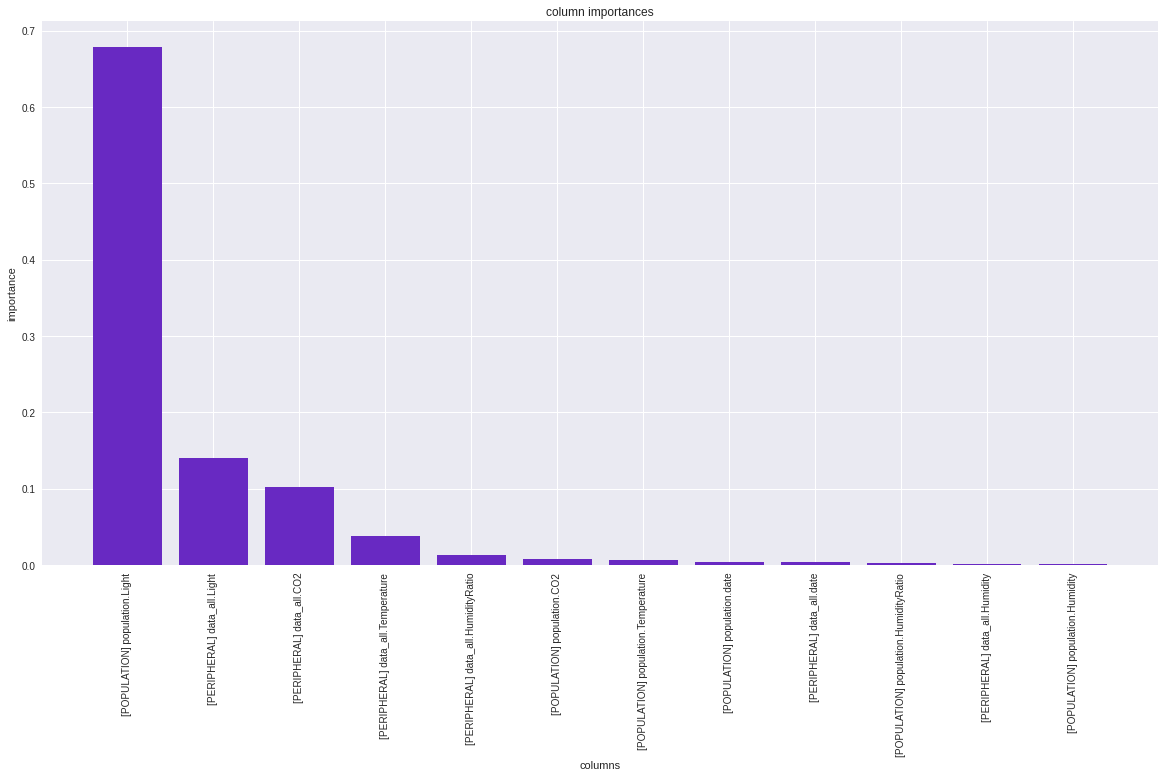

In [21]:
names, importances = pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("columns")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

In [22]:
pipe.columns.to_pandas()

,name,marker,table,importance,target
0,CO2,[PERIPHERAL],data_all,0.102797,Occupancy
1,Humidity,[PERIPHERAL],data_all,0.001841,Occupancy
2,HumidityRatio,[PERIPHERAL],data_all,0.013586,Occupancy
3,Light,[PERIPHERAL],data_all,0.140016,Occupancy
4,Temperature,[PERIPHERAL],data_all,0.038488,Occupancy
5,date,[PERIPHERAL],data_all,0.003636,Occupancy
6,CO2,[POPULATION],population,0.007362,Occupancy
7,Humidity,[POPULATION],population,0.001260,Occupancy
8,HumidityRatio,[POPULATION],population,0.002970,Occupancy
9,Light,[POPULATION],population,0.678229,Occupancy


As we can see, about 80% of the predictive power comes from the *Light* column. The second most important column is the *Temperature* column, we contributes about 7% of the predictive power.

 ### 2.5 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` module.

In [23]:
# Creates a folder named occupancy_pipeline containing
# the SQL code.
pipe.features.to_sql().save("occupancy_pipeline")

## 3. Conclusion

This tutorial demonstrates that relational learning is a powerful tool for time series. We able to outperform the benchmarks for a scientific paper on a simple public domain time series data set using relatively little effort.

If you want to learn more about getML, check out the [official documentation](https://getml.com/product).

# Next Steps

This tutorial went through the basics of applying getML to multirvariate time series and hyperparameter tuning.

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.